In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
import scipy.stats
import scipy.interpolate
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from sklearn import tree
import copy
import calendar
#import seaborn as sns

import plotting
import dataset_fctns
import modelling_fctns
import seaborn as sns
#from dwd_phenpy import Phenology_set

#import openeo
#import ee
## Trigger the authentication flow.
#ee.Authenticate()#(auth_mode='localhost')
# Initialize the library.
#ee.Initialize(project='ee-martinparker637')

In [2]:
hyras_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\tas_hyras_5_1951_2020_v5-0_de.nc').sel(time=slice('2020-01-01', '2020-12-31'))
hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])
#hyras_data = hyras_data.rename({'y': 'lat', 'x': 'lon'})
ERA5_data = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc').sel(time=slice('2020-01-01', '2020-12-31'))
ERA5_data = ERA5_data.rename({'latitude': 'lat', 'longitude': 'lon'})

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10956\2736271515.py:2: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data = hyras_data.drop(['x', 'y']).rename({'x': 'lon', 'y': 'lat'})
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10956\2736271515.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['time_bnds', 'x_bnds', 'y_bnds'])
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_10956\2736271515.py:4: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  hyras_data= hyras_data.drop(['crs_HYRAS', 'number_of_stations'])


In [3]:
hyras_lon = hyras_data.lon.values
hyras_lat = hyras_data.lat.values
ERA5_lon = ERA5_data.lon.values
ERA5_lat = ERA5_data.lat.values
#hyras_LON, hyras_LAT = np.meshgrid(hyras_lon, hyras_lat)
ERA5_LON, ERA5_LAT = np.meshgrid(ERA5_lon, ERA5_lat)


In [37]:
hyras_data['ERA5 t2m'].isel(time=0)
ERA5_interpolator((hyras_lat, hyras_lon)).shape

(220, 240)

In [4]:
ERA5_data['t2m mean'] = ERA5_data.t2m.mean(dim='time')
hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.zeros(hyras_data.tas.values.shape))
interpolated_temps = []
for day in range(366):#366
    print(day)
    ERA5_interpolator = scipy.interpolate.RegularGridInterpolator((ERA5_lat, ERA5_lon), ERA5_data.t2m.values[day, :, :], method='linear', bounds_error=False, fill_value=None)
    interpolated_temps.append(ERA5_interpolator((hyras_lat, hyras_lon)))

hyras_data['ERA5 t2m'] = (('time', 'lat', 'lon'), np.array(interpolated_temps))#ERA5_interpolator((hyras_lat, hyras_lon))#hyras_data.assign({'ERA5 t2m':(('lat', 'lon'), ERA5_interpolator((hyras_lat, hyras_lon)))})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [42]:
hyras_data['diff'] = hyras_data.tas - hyras_data['ERA5 t2m']

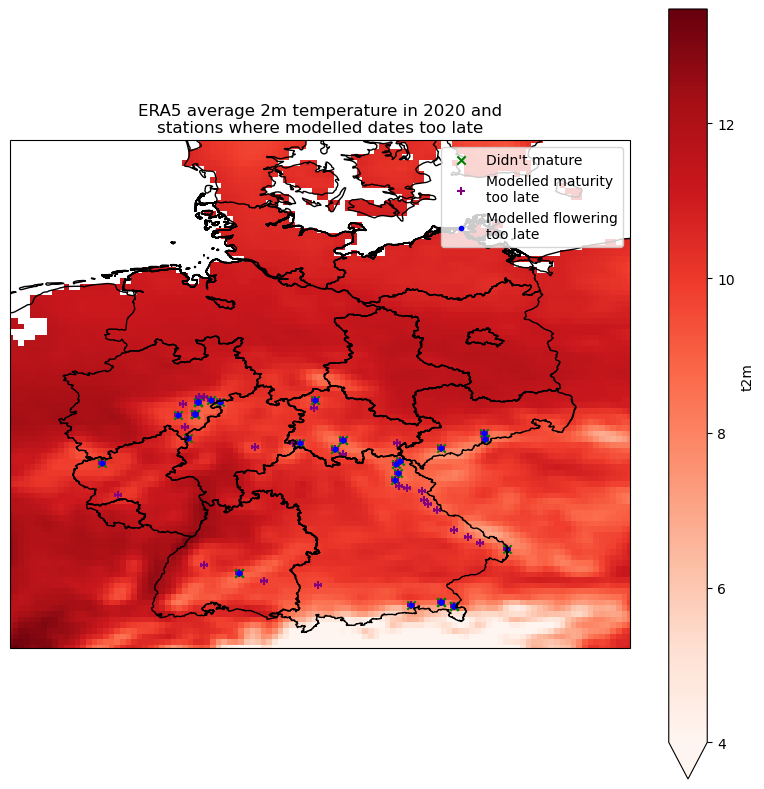

In [15]:
fig, ax = plotting.Germany_plot()
stat_locs = pd.read_csv('Saved_files/canm_latlon.csv')
bf_locs = pd.read_csv('Saved_files/cabf_latlon.csv')
lm_locs = pd.read_csv('Saved_files/calm_latlon.csv')
#for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
#    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
#    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
#stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
#, 'ro', transform=ccrs.PlateCarree())
#hyras_data['tas'].mean(dim='time').plot(cmap = 'Reds', ax=ax)#std(dim='time').plot(vmax=1)#.plot(vmin = -1, vmax = 1, cmap = 'coolwarm')#.isel(time=150)vmin = 0, vmax = 20, 
temp_map = ERA5_data['t2m'].mean(dim='time').plot(cmap = 'Reds', ax=ax, vmin = 4)
ax.set_title('ERA5 average 2m temperature in 2020 and\nstations where modelled dates too late')
#plt.colorbar(temp_map, label='Temperature (°C)')
#hyras_data['diff'].mean(dim='time').plot(cmap = 'coolwarm', ax=ax, vmin = -1, vmax = 1)
ax.scatter(stat_locs['lon'], stat_locs['lat'], color = 'green', marker='x', label='Didn\'t mature')
ax.scatter(lm_locs['lon'], lm_locs['lat'], color = 'purple', marker='+', label='Modelled maturity\ntoo late')
ax.scatter(stat_locs['lon'], stat_locs['lat'], color = 'blue', marker='.', label='Modelled flowering\ntoo late')
ax.legend()

In [65]:
hyras_interpolator = scipy.interpolate.RegularGridInterpolator((hyras_lat, hyras_lon), hyras_data.tas.values, method='linear', bounds_error=False, fill_value=None)

ValueError: The points in dimension 1 must be strictly ascending or descending

In [45]:
ERA5_data.lat.sortby('lat')

<xarray.DataArray 'lat' (lat: 91)> Size: 728B
array([47. , 47.1, 47.2, 47.3, 47.4, 47.5, 47.6, 47.7, 47.8, 47.9, 48. , 48.1,
       48.2, 48.3, 48.4, 48.5, 48.6, 48.7, 48.8, 48.9, 49. , 49.1, 49.2, 49.3,
       49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50. , 50.1, 50.2, 50.3, 50.4, 50.5,
       50.6, 50.7, 50.8, 50.9, 51. , 51.1, 51.2, 51.3, 51.4, 51.5, 51.6, 51.7,
       51.8, 51.9, 52. , 52.1, 52.2, 52.3, 52.4, 52.5, 52.6, 52.7, 52.8, 52.9,
       53. , 53.1, 53.2, 53.3, 53.4, 53.5, 53.6, 53.7, 53.8, 53.9, 54. , 54.1,
       54.2, 54.3, 54.4, 54.5, 54.6, 54.7, 54.8, 54.9, 55. , 55.1, 55.2, 55.3,
       55.4, 55.5, 55.6, 55.7, 55.8, 55.9, 56. ])
Coordinates:
    number   int64 8B ...
  * lat      (lat) float64 728B 47.0 47.1 47.2 47.3 47.4 ... 55.7 55.8 55.9 56.0
Attributes:
    units:             degrees_north
    standard_name:     latitude
    long_name:         latitude
    stored_direction:  decreasing

In [61]:
hyras_data.reindex({'lat':ERA5_data.lat, 'lon':ERA5_data.lon}, method='nearest')

ValueError: cannot reindex or align along dimension 'lat' because of conflicting dimension sizes: {91, 220} (note: an index is found along that dimension with size=91)

In [60]:
hyras_data.interp_like(ERA5_data)#({'lat':ERA5_data.lat.sortby('lat').values, 'lon':ERA5_data.lon.sortby('lon').values},method='nearest')# 'time':np.datetime64('2020-05-19')}, method='nearest')

ValueError: Input DataArray is not 1-D.

In [27]:
hyras_data.reindex(lat=ERA5_data['lat'], lon=ERA5_data['lon'], method='nearest')

<xarray.Dataset> Size: 78MB
Dimensions:             (time: 366, bnds: 2, y: 220, x: 240)
Coordinates:
  * time                (time) datetime64[ns] 3kB 2020-01-01T12:00:00 ... 202...
    lon                 (y, x) float64 422kB ...
    lat                 (y, x) float64 422kB ...
  * x                   (x) float32 960B 3.502e+06 3.508e+06 ... 4.698e+06
  * y                   (y) float32 880B 2.102e+06 2.108e+06 ... 3.198e+06
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 6kB ...
    x_bnds              (x, bnds) float32 2kB ...
    y_bnds              (y, bnds) float32 2kB ...
    crs_HYRAS           int32 4B ...
    tas                 (time, y, x) float32 77MB ...
    number_of_stations  (time) float64 3kB ...
Attributes: (12/19)
    source:                 surface observations
    Conventions:            CF-1.8
    realization:            v5.0
    project_id:             HYRAS
    input_data_status:      non-realtime
    level_type:             surface
    ...                     ...
    horizontal_resolution:  5 km
    title:                  gridded_temperature_dataset_(HYRAS-DE TAS)
    institution:            Deutscher Wetterdienst (DWD)
    creation_date:          created at 2022-12-04 13:12:56
    filename:               tas_hyras_5_1951_2020_v5-0_de.nc
    unique_dataset_id:      DWD_HYRAS_DE_tas_v5.0_1951_2020_day_00638C9CD8

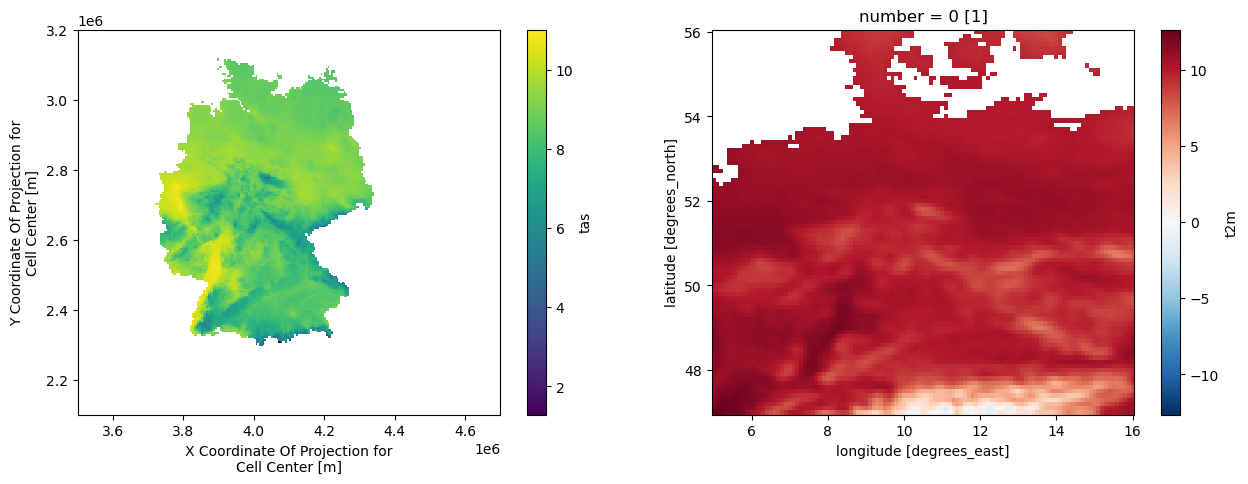

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
hyras_data['tas'].mean(dim='time').plot(ax=axs[0])
ERA5_data['t2m'].mean(dim='time').plot(ax=axs[1])

In [11]:
stat_locs['Referenzjahr'].unique()

array([2004., 2010., 2012., 2015., 2011., 2014., 2007., 2002., 2008.,
       2020., 2016.])

IndexError: list index out of range

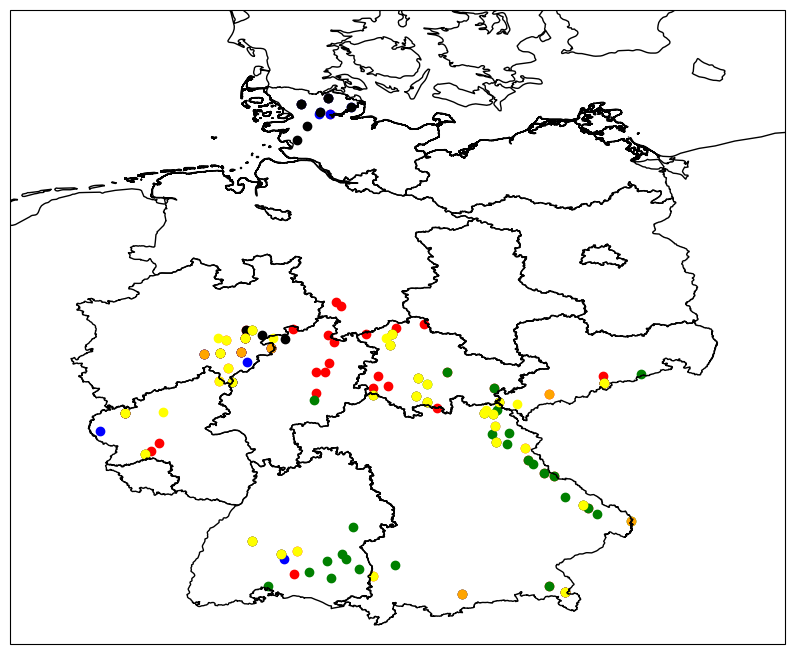

In [15]:
fig, ax = plotting.Germany_plot()
stat_locs = pd.read_csv('Saved_files/canm_latlon.csv')
for year_index, year in enumerate(stat_locs['Referenzjahr'].unique()):
    stat_locs_year = stat_locs.where(stat_locs['Referenzjahr'] == year).dropna()
    ax.scatter(stat_locs_year['lon'], stat_locs_year['lat'], label=year, color = ['r', 'g', 'b', 'k', 'purple', 'orange', 'yellow'][year_index])#, 'ro', transform=ccrs.PlateCarree())
stat_locs = stat_locs.where(stat_locs['Referenzjahr'] == 2004).dropna()
ax.scatter(stat_locs['lon'], stat_locs['lat'])#, 'ro', transform=ccrs.PlateCarree())

In [2]:
for y in range(2010, 2011):
    print(y)

2010


In [16]:
ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2020.nc')
#for year in range(2002, 2011):
#    ds = xr.concat([ds, xr.open_dataset(f'C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_{year}.nc')], dim='valid_time')
ds = ds.rename({'valid_time':'time', 'latitude':'lat', 'longitude':'lon'})
ds = ds.sortby('time')

In [17]:
#d2m = ds['d2m'].resample(time="1D").mean()
t2m = ds['t2m'].resample(time="1D").mean()
t2max = ds['t2m'].resample(time="1D").max()

KeyboardInterrupt: 

In [ ]:
#t2max['t2max'] = t2max
#t2max = t2max.drop('t2m')
t2max = t2max.rename('t2max')

In [ ]:
t2min = ds['t2m'].resample(time="1D").min()
#t2min['t2min'] = t2min['t2m']
#t2min = t2min.drop('t2m')
t2min = t2min.rename('t2min')

In [ ]:
ds_for_driver = xr.merge([t2m, t2max, t2min])

In [ ]:
ds_for_driver['t2m'] += -273.15
ds_for_driver['t2max'] += -273.15
ds_for_driver['t2min'] += -273.15

In [9]:
ds_for_driver['Averaging_Discrepancy'] = (ds_for_driver['t2max'] + ds_for_driver['t2min'])/2 - ds_for_driver['t2m']

In [11]:
diffs = ds_for_driver['Averaging_Discrepancy'].mean(dim='time')

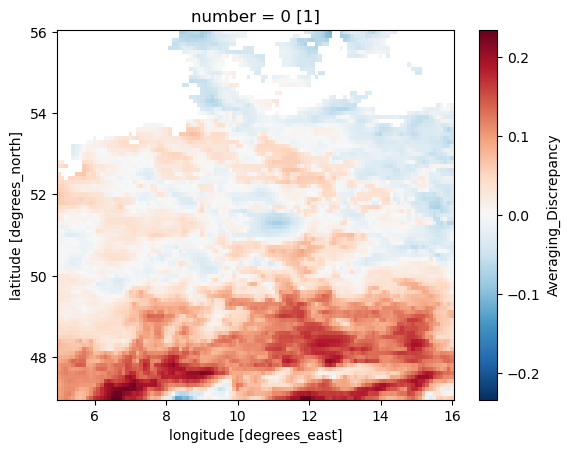

In [12]:
diffs.plot()

In [7]:
ds_for_solrad = ds.where((ds['time.hour'] > 5)*(ds['time.hour'] < 19), drop=True)
ssrd = ds_for_solrad['ssrd'].resample(time="1D").mean()

: 

In [ ]:
tp = ds['tp'].resample(time="1D").sum()

In [ ]:
ds_for_driver = xr.merge([d2m, t2m, ssrd, tp, t2max, t2min])
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds_for_driver = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
ds_for_driver['t2m'] += -273.15
ds_for_driver['t2max'] += -273.15
ds_for_driver['t2min'] += -273.15
#ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
#ds.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')
#ds3 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2018_2024.nc')

In [16]:
#ds = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
#ds.close()
ds_for_driver.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001_2010.nc')
#ds_to_save = xr.concat([ds_for_driver, ds], dim='time')
#ds_to_save

In [3]:
ds1

<xarray.Dataset> Size: 827MB
Dimensions:    (latitude: 91, longitude: 111, time: 5114)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 728B 56.0 55.9 55.8 55.7 ... 47.2 47.1 47.0
  * longitude  (longitude) float64 888B 5.0 5.1 5.2 5.3 ... 15.7 15.8 15.9 16.0
  * time       (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m        (time, latitude, longitude) float32 207MB ...
    t2m        (time, latitude, longitude) float32 207MB ...
    ssrd       (time, latitude, longitude) float32 207MB ...
    tp         (time, latitude, longitude) float32 207MB ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [13]:
ds1 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2011_2024.nc')
ds2 = xr.open_dataset('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land_2001_2010.nc')
ds2.close()
ds2 = ds2.where(ds2['time'] < np.datetime64('2011-01-01'), drop = True)
ds2.to_netcdf('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\Saved_files\\ERA5\\ERA5_land2_2001_2010.nc')
#ds_to_save = xr.concat([ds1, ds2], dim='time')

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'rasterio']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [8]:
np.datetime64('2011-01-01')

numpy.datetime64('2011-01-01')

In [5]:
print(ds1['time'].min().values,
      ds2['time'].max().values)

2011-01-01T00:00:00.000000000 2011-12-31T00:00:00.000000000


In [22]:
ds1

<xarray.Dataset> Size: 827MB
Dimensions:    (latitude: 91, longitude: 111, time: 5114)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 728B 56.0 55.9 55.8 55.7 ... 47.2 47.1 47.0
  * longitude  (longitude) float64 888B 5.0 5.1 5.2 5.3 ... 15.7 15.8 15.9 16.0
  * time       (time) datetime64[ns] 41kB 2011-01-01 2011-01-02 ... 2024-12-31
Data variables:
    d2m        (time, latitude, longitude) float32 207MB ...
    t2m        (time, latitude, longitude) float32 207MB ...
    ssrd       (time, latitude, longitude) float32 207MB ...
    tp         (time, latitude, longitude) float32 207MB ...
Attributes: (12/32)
    GRIB_paramId:                             168
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      10101
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                2 metre dewpoint temperature
    units:                                    K
    standard_name:                            unknown
    GRIB_surface:                             0.0